In [2]:
import pandas as pd
import numpy as np
import scipy as sp


In [3]:
#visualization libraries
#import plotly
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sklearn

import pyod

## Generating points with outliers

https://pyod.readthedocs.io/en/latest/pyod.utils.html#pyod.utils.data.generate_data

Utility function to generate synthesized data. Normal data is generated by a multivariate Gaussian distribution and outliers are generated by a uniform distribution.

In [5]:
from pyod.utils.data import generate_data, generate_data_clusters

In [6]:
contamination = 0.1  # percentage of outliers
n_train = 800  # number of training points
n_test = 200  # number of testing points

X_train, X_test, y_train, y_test = generate_data_clusters(
    n_train=n_train, n_test=n_test,
    n_clusters=2,
    contamination=contamination,
    random_state=0)

In [7]:
# convert to pandas dataframes and series for plotting
# train dataset
df_train = pd.DataFrame(X_train, columns=['X1', 'X2'])
df_train['label'] = y_train
df_train = df_train.astype({'label':'int8'})
# test dataset
df_test = pd.DataFrame(X_test, columns=['X1', 'X2'])
df_test['label'] = y_test
df_test = df_test.astype({'label':'int8'})

In [8]:
df = pd.concat([df_train, df_test], axis=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 199
Data columns (total 3 columns):
X1       1000 non-null float64
X2       1000 non-null float64
label    1000 non-null int8
dtypes: float64(2), int8(1)
memory usage: 24.4 KB


In [10]:
df.head()

,X1,X2,label
0,-1.218662,-1.843344,0
1,-2.108748,-3.050389,0
2,-1.135628,-2.457115,0
3,-2.857704,-3.056842,0
4,-1.290912,-2.593036,0


## Plotting the points

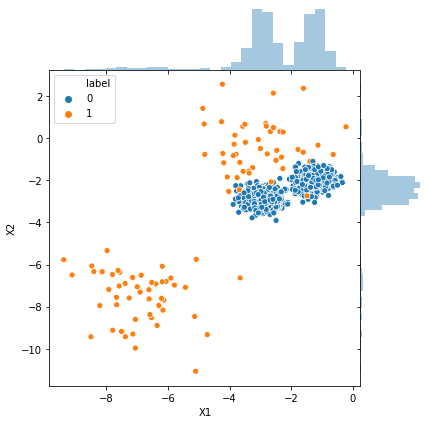

In [11]:
# Use JointGrid directly to draw a custom plot
grid = sns.JointGrid(data=df, x='X1', y='X2', space=0, height=6, ratio=5)
grid.plot_joint(sns.scatterplot, data=df, hue='label')
grid.plot_marginals(sns.distplot, kde=False);

## Outliers detection

In [12]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN   # kNN detector

### Descriptive statistics (doesn't work well anymore)

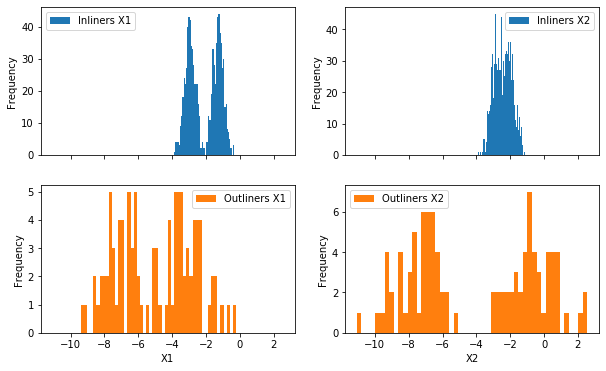

In [30]:
fig, axes = plt.subplots(2,2,figsize=(10,6), sharex=True)
df[df.label == 0]['X1'].plot.hist(bins=50, ax=axes[0][0], label='Inliners X1', legend=True)
df[df.label == 0]['X2'].plot.hist(bins=50, ax=axes[0][1], label='Inliners X2', legend=True)
df[df.label == 1]['X1'].plot.hist(bins=50, ax=axes[1][0], label='Outliners X1', legend=True, color='C1')
df[df.label == 1]['X2'].plot.hist(bins=50, ax=axes[1][1], label='Outliners X2', legend=True, color='C1')
axes[1][0].set_xlabel('X1')
axes[1][1].set_xlabel('X2');

### kNN detector

In [51]:
# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

### Formating results

In [52]:
results_knn = df_test.copy()
results_knn['predicted_label'] = y_test_pred
results_knn = results_knn.astype({'predicted_label':'int8'})
results_knn['prediction_score'] = y_test_scores
results_knn['is_rightly_labeled'] = results_knn['label'] == results_knn['predicted_label']

In [53]:
results_knn.head()

,X1,X2,label,predicted_label,prediction_score,is_rightly_labeled
0,-7.583525,-7.021574,1,1,0.592324,True
1,-6.527652,-6.849149,1,1,0.514707,True
2,-2.869802,-2.590366,0,0,0.067576,True
3,-0.897394,-1.450915,0,0,0.129769,True
4,-2.981159,-2.974708,0,0,0.057974,True


### Evaluation

In [56]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

#### Compute confusion matrix to evaluate the accuracy of a classification

By definition a confusion matrix $C$
is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$.

In [66]:
pd.DataFrame(
    confusion_matrix(y_true = results_knn.label, y_pred = results_knn.predicted_label),
    index=['true inliners', 'true outliers'],
    columns=['predicted inliners', 'predicted outliers'],
)

,predicted inliners,predicted outliers
true inliners,178,2
true outliers,3,17


#### Compute precision, recall, F-measure and support for each class

The **precision** is the ratio **tp / (tp + fp)** where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio **tp / (tp + fn)** where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The **F-beta score** can be interpreted as a **weighted harmonic mean of the precision and recall**, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The **support** is the number of occurrences of each class in y_true.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [59]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_true=results_knn.label, y_pred = results_knn.predicted_label)

In [64]:
pd.DataFrame(
    np.vstack([precision, recall, fbeta_score, support]),
    index=['precision', 'recall', 'fbeta_score', 'support'],
    columns=['inliners', 'outliers']
)

,inliners,outliers
precision,0.983425,0.894737
recall,0.988889,0.850000
fbeta_score,0.986150,0.871795
support,180.000000,20.000000


### Visualize the results

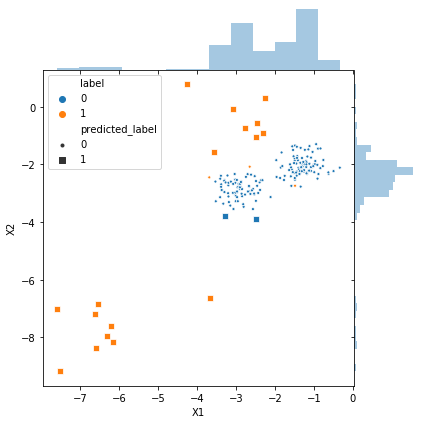

In [67]:
# Use JointGrid directly to draw a custom plot
grid = sns.JointGrid(data=results_knn, x='X1', y='X2', space=0, height=6, ratio=5)
grid.plot_joint(sns.scatterplot, 
                data=results_knn, 
                hue='label', 
                style='predicted_label', 
                markers=['.', 's'])
grid.plot_marginals(sns.distplot, kde=False)

### Cross validation

In [76]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer

In [80]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
# strategy to split the train and test datasets
cv = ShuffleSplit(n_splits=20, test_size=0.3, random_state=0)
# scoring function
f1_scorer = make_scorer(fbeta_score, beta=1)
# running the cross validation
cv_f1_scores = pd.Series(
    cross_val_score(
        clf, 
        df[['X1','X2']], 
        df['label'], 
        cv=cv, 
        scoring=f1_scorer,
    )
) 

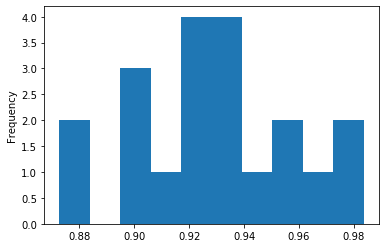

In [87]:
cv_f1_scores.plot.hist()